# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [1]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Clean Britney playlist data

In [2]:
britney_df = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [3]:
britney_df =britney_df.drop_duplicates(subset='track_id')
britney_df.shape

(1193, 21)

In [4]:
britney_df = britney_df.dropna()
britney_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1189,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1190,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1191,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


### 2. Read training data 

In [5]:
genre_names = ["Jazz", "Pop", "Reggae", "Classical", "Country"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

Jazz
Pop
Reggae
Classical
Country


In [6]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((479, 7), (8856, 22))

In [7]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [8]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8852, 22)

In [9]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8746, 22)

<AxesSubplot:>

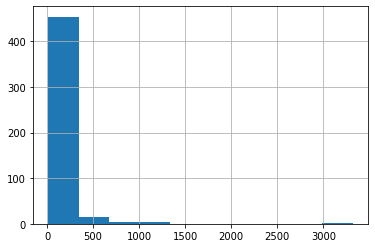

In [10]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

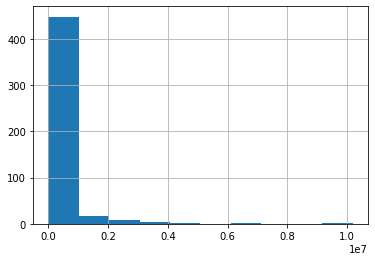

In [11]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [12]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

classical    0.272925
jazz         0.199634
pop          0.188772
reggae       0.186028
country      0.152641
Name: genre, dtype: float64

### 2. Refine the training data

In [51]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWVqfgj8NZEp1,Coffee Table Jazz,140,spotify,Spotify,2282279,jazz
1,37i9dQZF1DXbITWG1ZJKYt,Jazz Classics,100,spotify,Spotify,1905763,jazz
2,37i9dQZF1DX4wta20PHgwo,Late Night Jazz,80,spotify,Spotify,1852668,jazz
3,37i9dQZF1DX0SM0LYsmbMT,Jazz Vibes,350,spotify,Spotify,1775132,jazz
4,37i9dQZF1DWTbzY5gOVvKd,Jazzy Romance,60,spotify,Spotify,996283,jazz


In [52]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [53]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [54]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    2407.000000
mean        0.762869
std         0.174076
min         0.000000
25%         0.663653
50%         0.826147
75%         0.894885
max         1.000000
Name: loudness, dtype: float64

In [55]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()

count    2407.000000
mean        0.527422
std         0.154373
min         0.000000
25%         0.409178
50%         0.486401
75%         0.623485
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [56]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
genre_id                int8
dtype: object

In [57]:
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

In [58]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,2wOlZrHUpRP9hQbqbV9Ae5,Together,0Cioop2zjxXxtcPUme7R46,Matthew Halsall,1fcREbFQfCqfwxXkxGgvV7,672520,2009-10-26,61,0.401,0.0236,...,0.978,0.57900,0.1020,0.163,0.516468,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,11.208667,2
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,41sYqKPEygmvQrLXKpzWJU,167121,2020-04-17,62,0.327,0.1450,...,0.945,0.88400,0.0910,0.136,0.836329,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,2.785350,2
2,2R1vQwYTC0sl93C6oyVuHC,Simplicity,0FAC6FNPb4LsY5uyp0xTWF,Edward Simon,4GDYdHheKfIOBMjqOgTK6k,309586,2020-10-09,58,0.493,0.1070,...,0.881,0.90600,0.1220,0.126,0.426777,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,5.159767,2
3,7zzaZggdFuadOs0R7SuJlp,My Ideal,5CSkWcdoRvgBQDwJTZZstJ,Jerry Bergonzi,2T8WUL1jRlaGIqj36oD5O5,219766,2021-01-15,45,0.526,0.0767,...,0.802,0.00195,0.0978,0.247,0.526978,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,3.662767,2
4,7LIFp3v3CaTCvcG6fmceIg,Clouds,7c7414LKkYnuDPlkrwDg9a,Portraits in Jazz,3LEyIlY9P6z9Mvp6dpxk9d,283650,2020-11-27,56,0.338,0.1650,...,0.977,0.31500,0.1220,0.174,0.356400,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,4.727500,2


In [59]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'jazz', 3: 'pop', 4: 'reggae', 0: 'classical', 1: 'country'}

## 4. Train a KNN model

In [ ]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


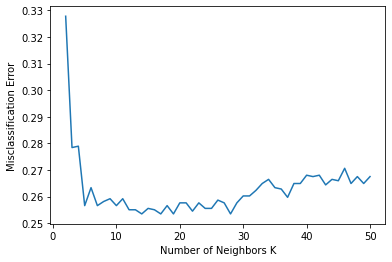

The optimal number of neighbors is 14 with score 74%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


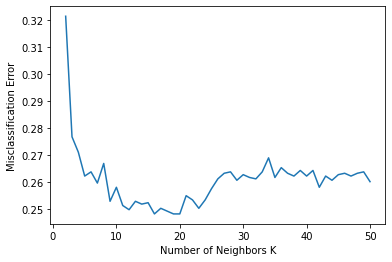

The optimal number of neighbors is 19 with score 75%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


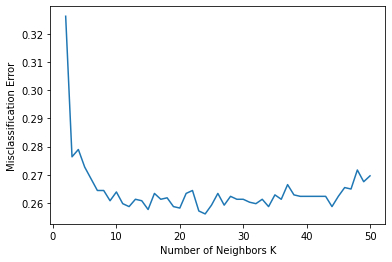

The optimal number of neighbors is 24 with score 74%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


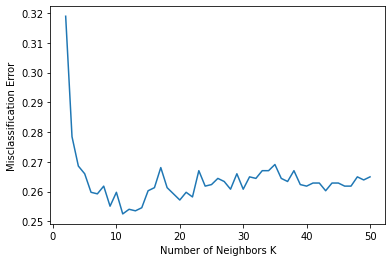

The optimal number of neighbors is 11 with score 74%


In [60]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [61]:
results_optimal_k

[14, 19, 24, 11]

### 5. Model Prediction

In [62]:
#normalize loudness and tempo
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [63]:
britney_df = britney_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

britney_df['predicted_genre_id'] = britney_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
britney_df['predicted_genre'] = britney_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
britney_df['predicted_genre_prob'] = britney_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
britney_df['all_genre_prob'] = britney_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 11


In [64]:
#explode genre probabilities into separate columns
britney_predicted_genre_prob = pd.DataFrame(britney_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
britney_predicted_genre_prob['track_id'] = britney_df['track_id']
britney_df = pd.merge(britney_df, britney_predicted_genre_prob, how='left', on='track_id')
britney_df = britney_df.drop(columns='all_genre_prob')
britney_df = britney_df.sort_values('predicted_genre_prob', ascending=False)
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,playlist_name,euclidean_dist,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
734,270TVH45y3aFzNSZQt1wsC,Starstruck,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,2FBA8NCSuQNi8jaR2Xjbal,217120,2008-01-01,0,0.876,0.631,...,270TVH45y3aFzNSZQt1wsC,0.102,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0
668,1dEy9Pl81QopSxNsPxXQxv,Stay,5pKCCKE2ajJHZ9KAiaK11H,Rihanna,4eddbruVtOqw8khwxSH6H2,240706,2012-12-11,67,0.621,0.310,...,1dEy9Pl81QopSxNsPxXQxv,0.153,2,jazz,1.0,0.0,0.0,1.0,0.0,0.0
658,1E2tRwT1GIHk1a8oYQMfjC,Teenage Crime - Radio Edit,5kp9Qhzri9LrDkzrtjt5Sh,Adrian Lux,72XSI1AWTvZbMrzCRvbtUK,170920,2010-08-02,40,0.646,0.833,...,1E2tRwT1GIHk1a8oYQMfjC,0.128,2,jazz,1.0,0.0,0.0,1.0,0.0,0.0
70,2lnzGkdtDj5mtlcOW2yRtG,"Whenever, Wherever",0EmeFodog0BfCgMzAIvKQp,Shakira,4DyMK9x2gnmRkRa16zHaEV,196160,2001-11-13,75,0.794,0.832,...,2lnzGkdtDj5mtlcOW2yRtG,0.020,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0
891,3aw9iWUQ3VrPQltgwvN9Xu,Family Affair,1XkoF8ryArs86LZvFOkbyr,Mary J. Blige,5QJmKwPveBV4IwLlo4OcG4,265866,2001-01-01,72,0.911,0.551,...,3aw9iWUQ3VrPQltgwvN9Xu,0.137,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0


Check out tracks with highest assigned probability

In [65]:
britney_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
734,Lady Gaga,Starstruck,reggae,1.000000
668,Rihanna,Stay,jazz,1.000000
658,Adrian Lux,Teenage Crime - Radio Edit,jazz,1.000000
70,Shakira,"Whenever, Wherever",reggae,1.000000
891,Mary J. Blige,Family Affair,reggae,1.000000
1058,Backstreet Boys,Everybody (Backstreet's Back) - Extended Version,reggae,1.000000
361,Jordin Sparks,Battlefield,pop,1.000000
1052,Christina Aguilera,Come on over Baby (All I Want Is You) - Radio ...,reggae,1.000000
1033,The Strokes,The Modern Age,jazz,1.000000
1030,Kings of Leon,Around The World,jazz,1.000000


View histogram of predicted genre probabilities

<AxesSubplot:>

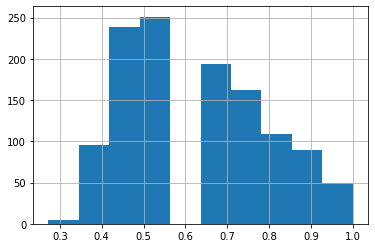

In [66]:
britney_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [67]:
britney_df['predicted_genre'].value_counts()

reggae       485
pop          373
country      280
jazz          51
classical      4
Name: predicted_genre, dtype: int64

In [68]:
#save data
britney_df.to_csv("data/Britney_Spears_playlist_tracks_data.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [69]:
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,playlist_name,euclidean_dist,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
734,270TVH45y3aFzNSZQt1wsC,Starstruck,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,2FBA8NCSuQNi8jaR2Xjbal,217120,2008-01-01,0,0.876,0.631,...,270TVH45y3aFzNSZQt1wsC,0.102,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0
668,1dEy9Pl81QopSxNsPxXQxv,Stay,5pKCCKE2ajJHZ9KAiaK11H,Rihanna,4eddbruVtOqw8khwxSH6H2,240706,2012-12-11,67,0.621,0.310,...,1dEy9Pl81QopSxNsPxXQxv,0.153,2,jazz,1.0,0.0,0.0,1.0,0.0,0.0
658,1E2tRwT1GIHk1a8oYQMfjC,Teenage Crime - Radio Edit,5kp9Qhzri9LrDkzrtjt5Sh,Adrian Lux,72XSI1AWTvZbMrzCRvbtUK,170920,2010-08-02,40,0.646,0.833,...,1E2tRwT1GIHk1a8oYQMfjC,0.128,2,jazz,1.0,0.0,0.0,1.0,0.0,0.0
70,2lnzGkdtDj5mtlcOW2yRtG,"Whenever, Wherever",0EmeFodog0BfCgMzAIvKQp,Shakira,4DyMK9x2gnmRkRa16zHaEV,196160,2001-11-13,75,0.794,0.832,...,2lnzGkdtDj5mtlcOW2yRtG,0.020,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0
891,3aw9iWUQ3VrPQltgwvN9Xu,Family Affair,1XkoF8ryArs86LZvFOkbyr,Mary J. Blige,5QJmKwPveBV4IwLlo4OcG4,265866,2001-01-01,72,0.911,0.551,...,3aw9iWUQ3VrPQltgwvN9Xu,0.137,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0


In [70]:
britney_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'playlist_id',
       'playlist_name', 'euclidean_dist', 'predicted_genre_id',
       'predicted_genre', 'predicted_genre_prob', 'predicted_classical_prob',
       'predicted_country_prob', 'predicted_jazz_prob', 'predicted_pop_prob',
       'predicted_reggae_prob'],
      dtype='object')

In [71]:
#read data
britney_df=pd.read_csv("data/Britney_Spears_playlist_tracks_data.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,playlist_name,euclidean_dist,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
0,270TVH45y3aFzNSZQt1wsC,Starstruck,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,2FBA8NCSuQNi8jaR2Xjbal,217120,2008-01-01,0,0.876,0.631,...,270TVH45y3aFzNSZQt1wsC,0.102,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0
1,1dEy9Pl81QopSxNsPxXQxv,Stay,5pKCCKE2ajJHZ9KAiaK11H,Rihanna,4eddbruVtOqw8khwxSH6H2,240706,2012-12-11,67,0.621,0.310,...,1dEy9Pl81QopSxNsPxXQxv,0.153,2,jazz,1.0,0.0,0.0,1.0,0.0,0.0
2,1E2tRwT1GIHk1a8oYQMfjC,Teenage Crime - Radio Edit,5kp9Qhzri9LrDkzrtjt5Sh,Adrian Lux,72XSI1AWTvZbMrzCRvbtUK,170920,2010-08-02,40,0.646,0.833,...,1E2tRwT1GIHk1a8oYQMfjC,0.128,2,jazz,1.0,0.0,0.0,1.0,0.0,0.0
3,2lnzGkdtDj5mtlcOW2yRtG,"Whenever, Wherever",0EmeFodog0BfCgMzAIvKQp,Shakira,4DyMK9x2gnmRkRa16zHaEV,196160,2001-11-13,75,0.794,0.832,...,2lnzGkdtDj5mtlcOW2yRtG,0.020,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0
4,3aw9iWUQ3VrPQltgwvN9Xu,Family Affair,1XkoF8ryArs86LZvFOkbyr,Mary J. Blige,5QJmKwPveBV4IwLlo4OcG4,265866,2001-01-01,72,0.911,0.551,...,3aw9iWUQ3VrPQltgwvN9Xu,0.137,4,reggae,1.0,0.0,0.0,0.0,0.0,1.0


In [72]:
# Input seed track here
seed_track_name = 'Oops!...I Did It Again'

In [73]:
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

In [74]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[feature_cols]

In [75]:
seed_track_data = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
seed_track_data = seed_track_data[feature_cols].iloc[1]
seed_track_data

danceability        0.621000
energy              0.310000
loudness            0.487696
speechiness         0.028300
acousticness        0.945000
instrumentalness    0.000061
liveness            0.117000
valence             0.125000
tempo               0.343977
Name: 1, dtype: float64

In [76]:
seed_track_data['track_id'] = '6naxalmIoLFWR0siv8dnQQ'
seed_track_data

danceability                         0.621
energy                                0.31
loudness                          0.487696
speechiness                         0.0283
acousticness                         0.945
instrumentalness                  0.000061
liveness                             0.117
valence                              0.125
tempo                             0.343977
track_id            6naxalmIoLFWR0siv8dnQQ
Name: 1, dtype: object

In [77]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [78]:
britney_df['euclidean_dist'] = britney_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = britney_df[britney_df['track_id']!=seed_track_data['track_id']].sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

,track_name,artist_name,euclidean_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1,Stay,Rihanna,0.000,jazz,0.621,0.310,0.487696,0.0283,0.9450,0.000061,0.1170,0.125,0.343977
879,I Just Had Sex,The Lonely Island,0.000,country,0.621,0.802,0.765437,0.1180,0.0235,0.000000,0.1080,0.819,0.715648
1132,Teardrops On My Guitar - Radio Single Remix,Taylor Swift,0.000,pop,0.621,0.417,0.652581,0.0231,0.2880,0.000000,0.1190,0.289,0.264848
1129,My Old Santa Claus,Sia,0.000,country,0.621,0.885,0.796695,0.1540,0.0168,0.000000,0.0702,0.697,0.410957
939,I'm Like A Bird,Nelly Furtado,0.001,country,0.622,0.608,0.747532,0.0360,0.1380,0.000005,0.2730,0.607,0.196641
881,Let Me Love You,Mario,0.001,pop,0.622,0.593,0.580396,0.0916,0.1630,0.000000,0.0979,0.607,0.227809
476,Too Young,Phoenix,0.001,country,0.622,0.750,0.681946,0.0445,0.0625,0.000133,0.1270,0.905,0.539021
1051,I'm Like A Bird,Nelly Furtado,0.001,country,0.622,0.616,0.746406,0.0349,0.1470,0.000004,0.2180,0.598,0.196721
1164,Love Story,Taylor Swift,0.001,country,0.620,0.639,0.731519,0.0285,0.0186,0.000110,0.2060,0.340,0.391440
773,Marry You,Bruno Mars,0.001,pop,0.620,0.832,0.759656,0.0360,0.3320,0.000000,0.1040,0.481,0.562892


In [81]:
britney_df['manhattan_dist'] = britney_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = britney_df[britney_df['track_id']!=seed_track_data['track_id']].sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

,track_name,artist_name,manhattan_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1,Stay,Rihanna,0.000,jazz,0.621,0.310,0.487696,0.0283,0.9450,0.000061,0.1170,0.125,0.343977
879,I Just Had Sex,The Lonely Island,0.000,country,0.621,0.802,0.765437,0.1180,0.0235,0.000000,0.1080,0.819,0.715648
1129,My Old Santa Claus,Sia,0.000,country,0.621,0.885,0.796695,0.1540,0.0168,0.000000,0.0702,0.697,0.410957
1132,Teardrops On My Guitar - Radio Single Remix,Taylor Swift,0.000,pop,0.621,0.417,0.652581,0.0231,0.2880,0.000000,0.1190,0.289,0.264848
1051,I'm Like A Bird,Nelly Furtado,0.001,country,0.622,0.616,0.746406,0.0349,0.1470,0.000004,0.2180,0.598,0.196721
939,I'm Like A Bird,Nelly Furtado,0.001,country,0.622,0.608,0.747532,0.0360,0.1380,0.000005,0.2730,0.607,0.196641
881,Let Me Love You,Mario,0.001,pop,0.622,0.593,0.580396,0.0916,0.1630,0.000000,0.0979,0.607,0.227809
476,Too Young,Phoenix,0.001,country,0.622,0.750,0.681946,0.0445,0.0625,0.000133,0.1270,0.905,0.539021
773,Marry You,Bruno Mars,0.001,pop,0.620,0.832,0.759656,0.0360,0.3320,0.000000,0.1040,0.481,0.562892
168,Wake Me Up Before You Go-Go,Wham!,0.001,reggae,0.620,0.573,0.399243,0.0423,0.2710,0.000000,0.0607,0.897,0.142875


In [82]:
#compute cosine distances, audio features only
britney_df['cosine_dist'] = britney_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

britney_df.sort_values(by='cosine_dist',ascending=False).head()

#get top 10 nearest to seed_track_data
recommendation_df = britney_df[britney_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1,Stay,Rihanna,0.000000,jazz,0.621,0.310,0.487696,0.0283,0.945,0.000061,0.1170,0.1250,0.343977
46,Everytime (Glee Cast Version),Glee Cast,0.004099,jazz,0.505,0.349,0.481660,0.0270,0.904,0.000260,0.1480,0.0855,0.328197
110,"My Heart Will Go On - Love Theme from ""Titanic""",Céline Dion,0.004387,jazz,0.428,0.276,0.407633,0.0312,0.732,0.000005,0.1170,0.0382,0.259825
31,My All,Mariah Carey,0.006998,jazz,0.607,0.317,0.483604,0.0290,0.732,0.000045,0.0860,0.1110,0.318986
258,you broke me first,Tate McRae,0.012165,jazz,0.667,0.373,0.527344,0.0500,0.785,0.000000,0.0906,0.0823,0.425193
217,Hero,Mariah Carey,0.016422,jazz,0.501,0.378,0.528316,0.0290,0.735,0.000000,0.1190,0.1780,0.397617
549,Everytime,Britney Spears,0.016689,jazz,0.398,0.284,0.350182,0.0337,0.966,0.000086,0.1160,0.1140,0.328774
210,Someone Like You,Adele,0.017407,jazz,0.559,0.330,0.585563,0.0285,0.892,0.000000,0.0975,0.2850,0.497833
56,Empire State of Mind (Part II) Broken Down,Alicia Keys,0.022780,jazz,0.484,0.368,0.609454,0.0341,0.740,0.000038,0.1180,0.1420,0.218259
833,Hey There Delilah,Plain White T's,0.027721,pop,0.527,0.452,0.606385,0.0293,0.819,0.000000,0.1020,0.3110,0.290681


array([[<AxesSubplot:title={'center':'euclidean_dist'}>,
        <AxesSubplot:title={'center':'manhattan_dist'}>],
       [<AxesSubplot:title={'center':'cosine_dist'}>, <AxesSubplot:>]],
      dtype=object)

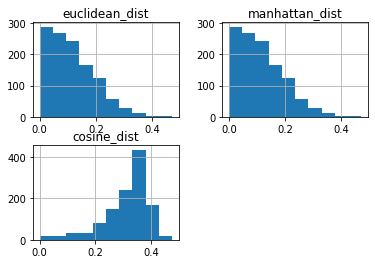

In [83]:
britney_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

Modify similarity criteria